In [23]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import plotnine as p9
import tensorflow_probability.substrates.jax.bijectors as tfb

import liesel_ptm as ptm

In [24]:
jax.config.update("jax_enable_x64", True)

In [25]:
from pathlib import Path

import dill as pickle

with open(Path.cwd() / ".." / "notebooks" / "y_ridge.pkl", "rb") as fp:
    y = pickle.load(fp)

In [26]:
# y = jnp.r_[y, y, y, y, y,y,y,y,y,y]
# y.shape

In [27]:
# y = jnp.r_[y,y]
# y.shape

In [28]:
nparam = 20
knots = ptm.bspline.OnionKnots(a=-4.0, b=4.0, nparam=nparam)

In [ ]:
model = ptm.LocScalePTM(y, knots.knots, bspline="onion", to_float32=False)
kernel_kwargs = {"da_target_accept": 0.9}
model.trafo += ptm.PTMCoef.new_rw1_fromzero(
    knots=knots.knots,
    scale=ptm.ScaleWeibull(
        jnp.array(0.2),
        scale=jnp.array(0.5),
        name="trafo0_scale",
        # inference=gs.MCMCSpec(
        #     gs.NUTSKernel, kernel_group="1", kernel_kwargs=kernel_kwargs
        # ),
        inference=gs.MCMCSpec(gs.IWLSKernel.untuned),
        bijector=tfb.Exp(),
    ),
    name="trafo0",
    inference=gs.MCMCSpec(gs.IWLSKernel.untuned),
    diagonalize_penalty=True,
    noncentered=True,
)
model.build()

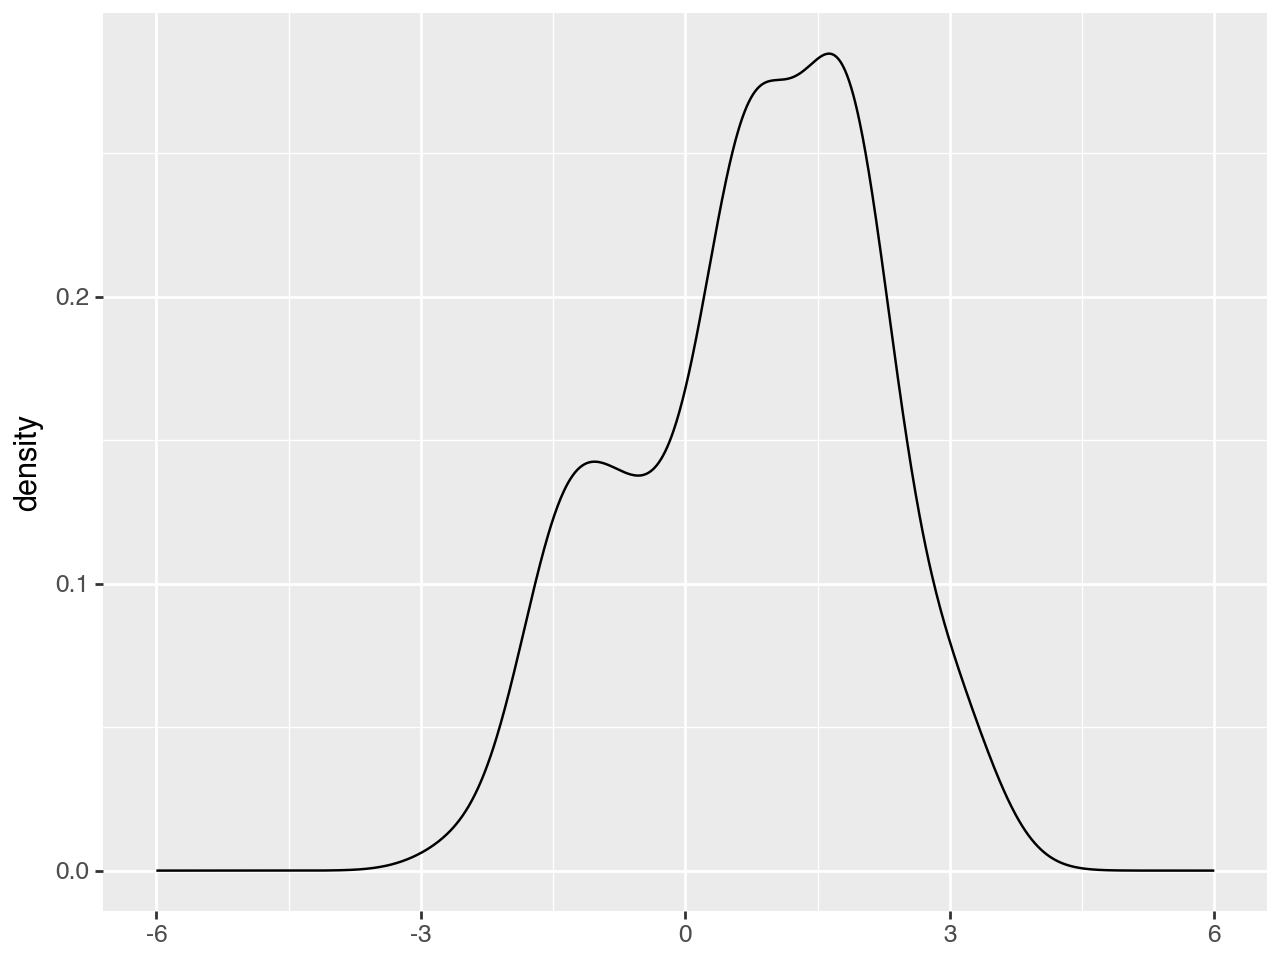

In [30]:
r_sample = model.response.value
(p9.ggplot() + p9.geom_density(p9.aes(r_sample)) + p9.xlim((-6.0, 6.0)))

In [31]:
import logging

logger = logging.getLogger("liesel_ptm")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

In [32]:
model.show_mcmc()

2025-12-12 16:15:41,012 - INFO - MCMC Setup for trafo0_scale_square_transformed: <bound method IWLSKernel.untuned of <class 'liesel.goose.iwls.IWLSKernel'>> in group 'None'.
2025-12-12 16:15:41,016 - INFO - MCMC Setup for trafo0_latent: <bound method IWLSKernel.untuned of <class 'liesel.goose.iwls.IWLSKernel'>> in group 'None'.
2025-12-12 16:15:41,017 - INFO - MCMC Setup for $\gamma_0$: <function scale_intercept_pgibbs at 0x12a840180> in group 'None'.
2025-12-12 16:15:41,018 - INFO - MCMC Setup for $\beta_0$: <function loc_intercept_pgibbs at 0x12a81fec0> in group 'None'.


In [33]:
results = model.run_mcmc(
    seed=2, warmup=2000, posterior=10 * 1000, thinning_posterior=10, strategy="manual"
)

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 500 transitions, 25 jitted together
100%|████████████████████████████████████████| 20/20 [00:03<00:00,  5.89chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 429, 445, 443, 439 / 500 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 909.04chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 22, 22, 19, 21 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1662.43ch

In [34]:
gs.Summary(results)

/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


Parameter summary:

                                          kernel      mean            sd  \
parameter                       index                                      
$\beta_0$                       ()     kernel_03  0.764880  1.110223e-16   
$\gamma_0$                      ()     kernel_02  0.285308  5.551115e-17   
trafo0_latent                   (0,)   kernel_01 -0.119274  1.051936e-14   
                                (1,)   kernel_01  0.245899  1.446065e-14   
                                (2,)   kernel_01 -0.176620  5.190293e-15   
                                (3,)   kernel_01  0.972416  8.426593e-14   
                                (4,)   kernel_01  0.037310  1.110223e-15   
                                (5,)   kernel_01 -0.512874  3.608225e-14   
                                (6,)   kernel_01 -0.396691  1.432188e-14   
                                (7,)   kernel_01 -0.302865  2.353673e-14   
                                (8,)   kernel_01  0.332409  1.665335e-15   
                                (9,)   kernel_01 -0.050218  6.938894e-16   
                                (10,)  kernel_01  0.277280  1.026956e-14   
                                (11,)  kernel_01  0.269958  1.926237e-14   
                                (12,)  kernel_01  0.094761  6.411538e-15   
                                (13,)  kernel_01 -0.182872  1.512679e-14   
                                (14,)  kernel_01 -0.067409  3.191891e-15   
                                (15,)  kernel_01 -0.178848  1.501577e-14   
                                (16,)  kernel_01 -0.343997  7.216450e-16   
                                (17,)  kernel_01 -0.093786  3.205769e-15   
                                (18,)  kernel_01  0.175550  5.218048e-15   
                                (19,)  kernel_01  0.023263  1.991463e-15   
trafo0_scale_square_transformed ()     kernel_00  1.751659  2.011653e-01   

                                         q_0.05     q_0.5    q_0.95  \
parameter                       index                                 
$\beta_0$                       ()     0.764880  0.764880  0.764880   
$\gamma_0$                      ()     0.285308  0.285308  0.285308   
trafo0_latent                   (0,)  -0.119274 -0.119274 -0.119274   
                                (1,)   0.245899  0.245899  0.245899   
                                (2,)  -0.176620 -0.176620 -0.176620   
                                (3,)   0.972416  0.972416  0.972416   
                                (4,)   0.037310  0.037310  0.037310   
                                (5,)  -0.512874 -0.512874 -0.512874   
                                (6,)  -0.396691 -0.396691 -0.396691   
                                (7,)  -0.302865 -0.302865 -0.302865   
                                (8,)   0.332409  0.332409  0.332409   
                                (9,)  -0.050218 -0.050218 -0.050218   
                                (10,)  0.277280  0.277280  0.277280   
                                (11,)  0.269958  0.269958  0.269958   
                                (12,)  0.094761  0.094761  0.094761   
                                (13,) -0.182872 -0.182872 -0.182872   
                                (14,) -0.067409 -0.067409 -0.067409   
                                (15,) -0.178848 -0.178848 -0.178848   
                                (16,) -0.343997 -0.343997 -0.343997   
                                (17,) -0.093786 -0.093786 -0.093786   
                                (18,)  0.175550  0.175550  0.175550   
                                (19,)  0.023263  0.023263  0.023263   
trafo0_scale_square_transformed ()     1.401466  1.767241  2.065200   

                                       sample_size     ess_bulk     ess_tail  \
parameter                       index                                          
$\beta_0$                       ()            4000  4000.000000  4000.000000   
$\gamma_0$                      ()            4000  4000.000000

In [35]:
results.get_posterior_transition_infos()["kernel_00"].acceptance_prob.mean()

Array(0.79437444, dtype=float64)

In [36]:
samples = results.get_posterior_samples()

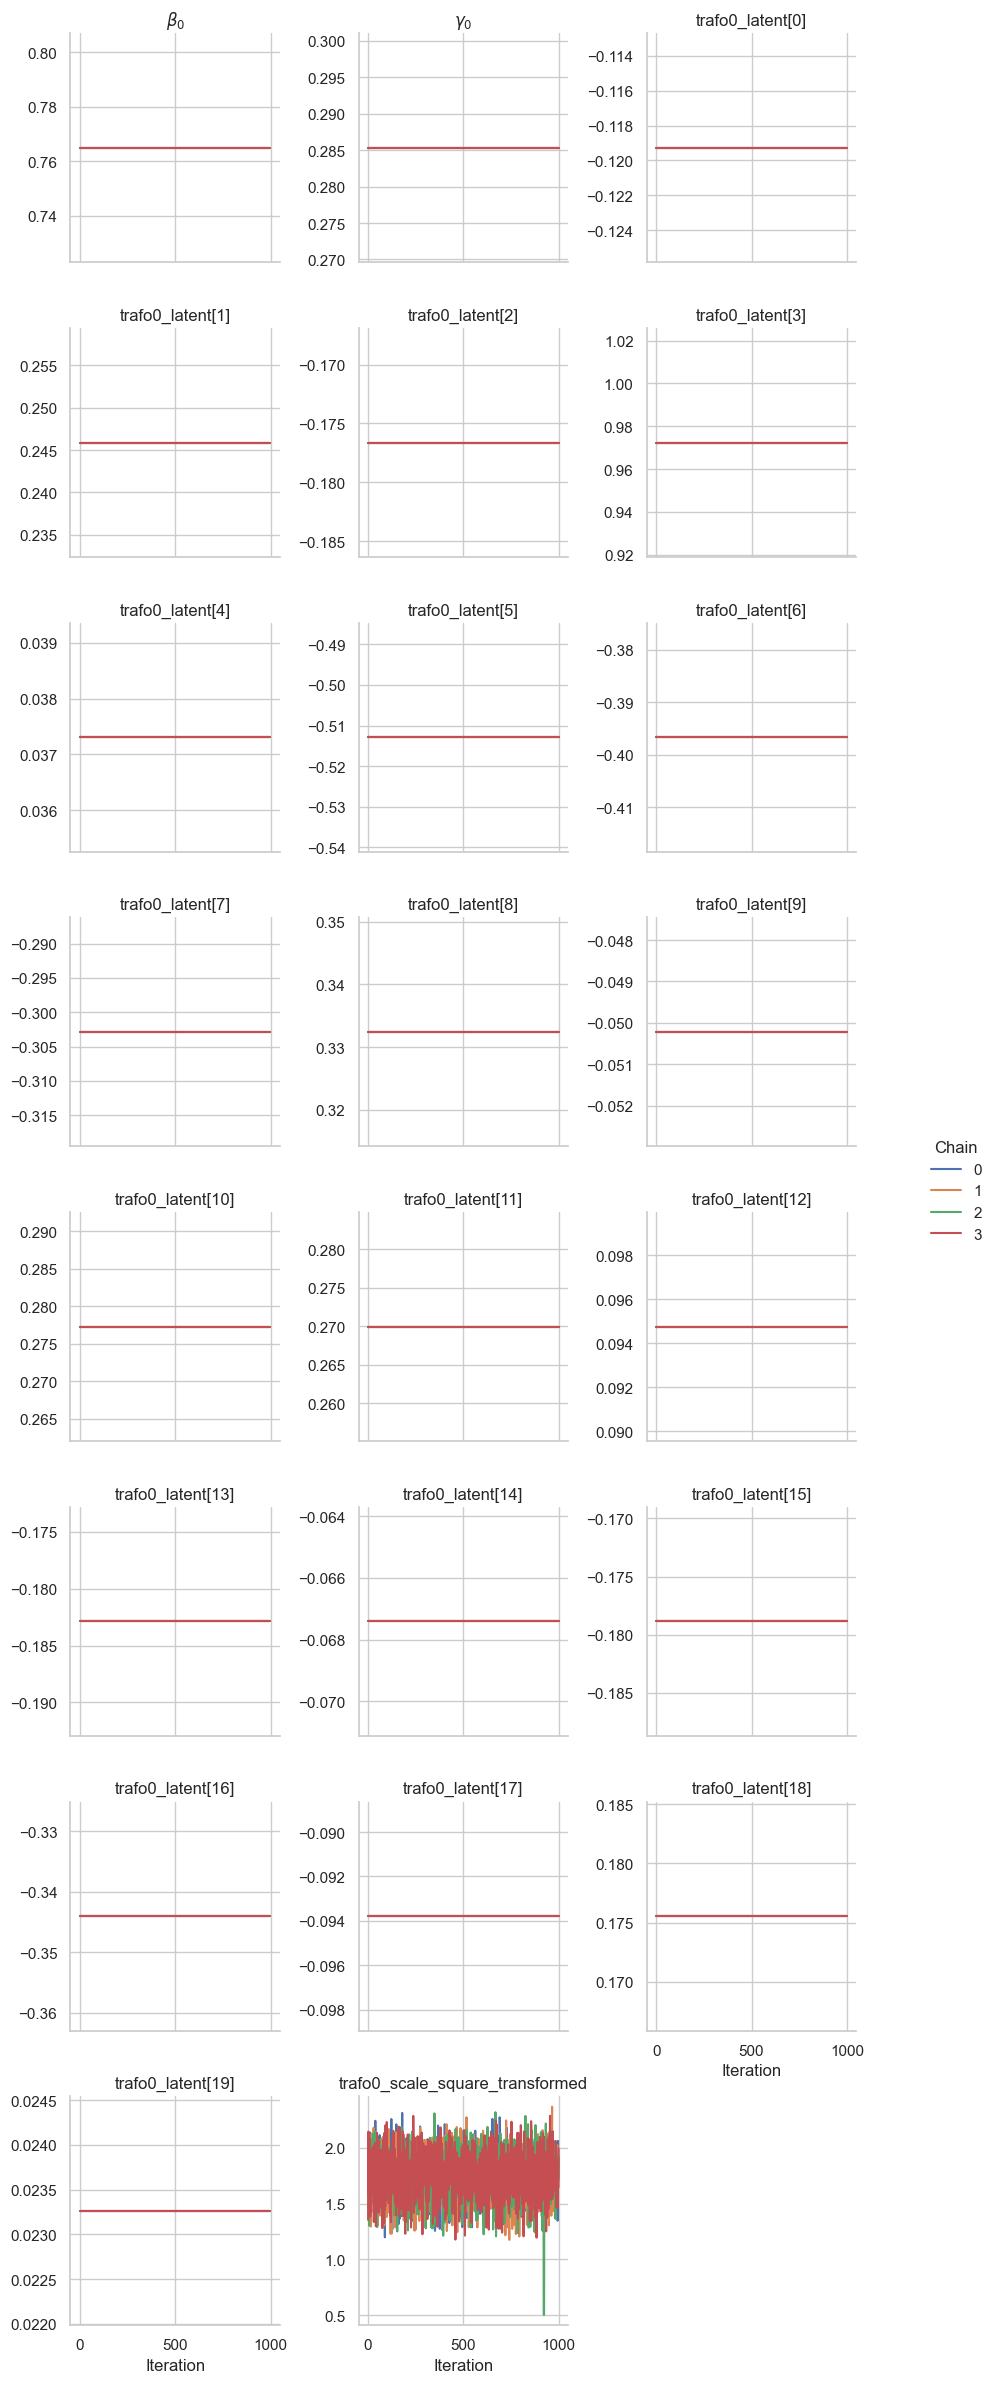

In [37]:
gs.plot_trace(jax.tree.map(jnp.squeeze, samples))

In [38]:
dist = model.init_dist(samples, loc=0.0, scale=1.0)
rgrid = jnp.linspace(-6.0, 6.0, 301)
probs = jnp.exp(dist.log_prob(rgrid))
z = dist.transformation_and_logdet(rgrid)[0]

/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


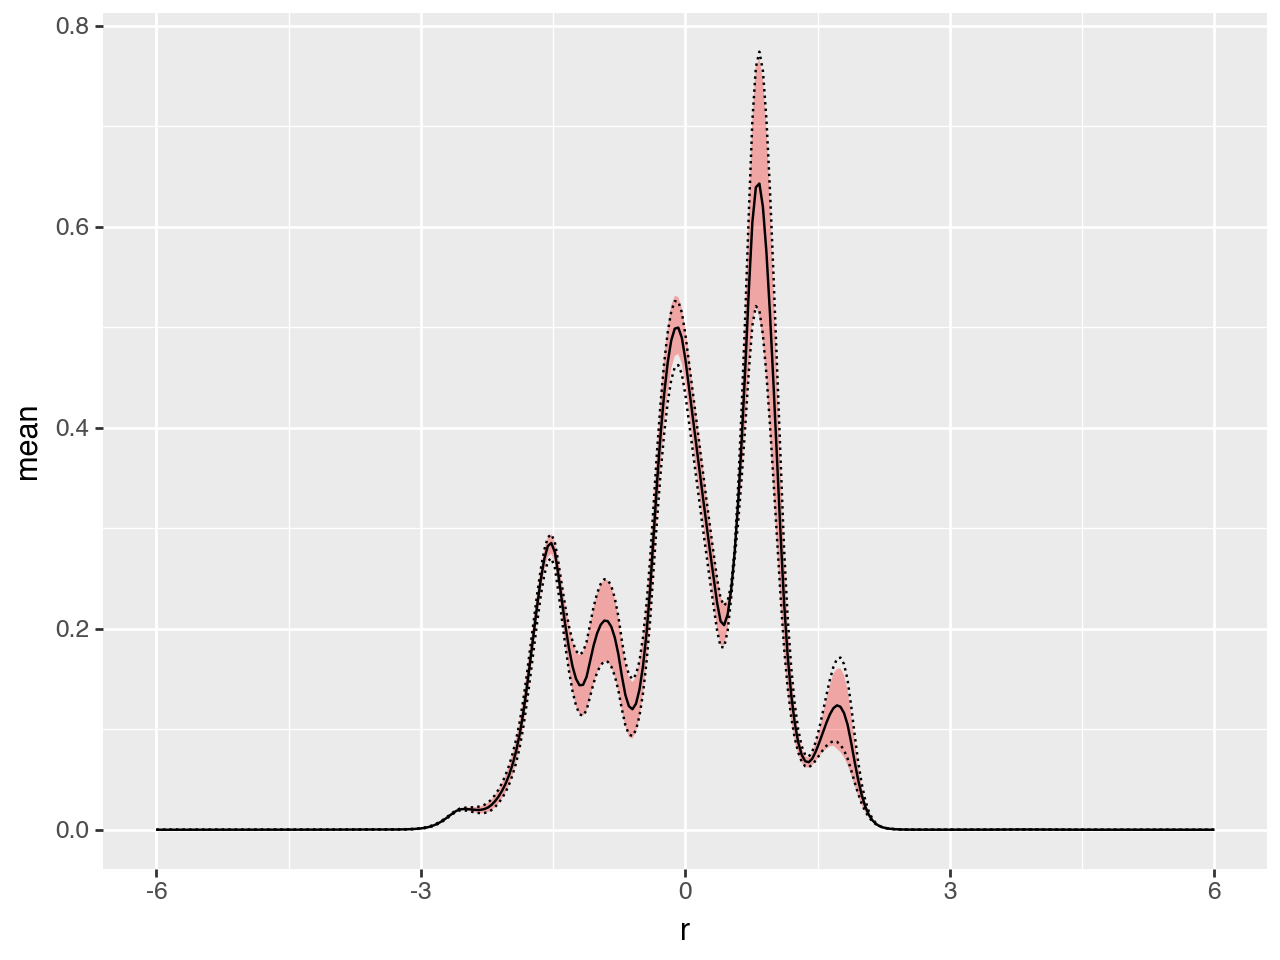

In [39]:
pdf_summary = gs.SamplesSummary({"pdf": probs}).to_dataframe().reset_index()
pdf_summary["r"] = rgrid

(
    p9.ggplot(pdf_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="red", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
)

/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel-ptm/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


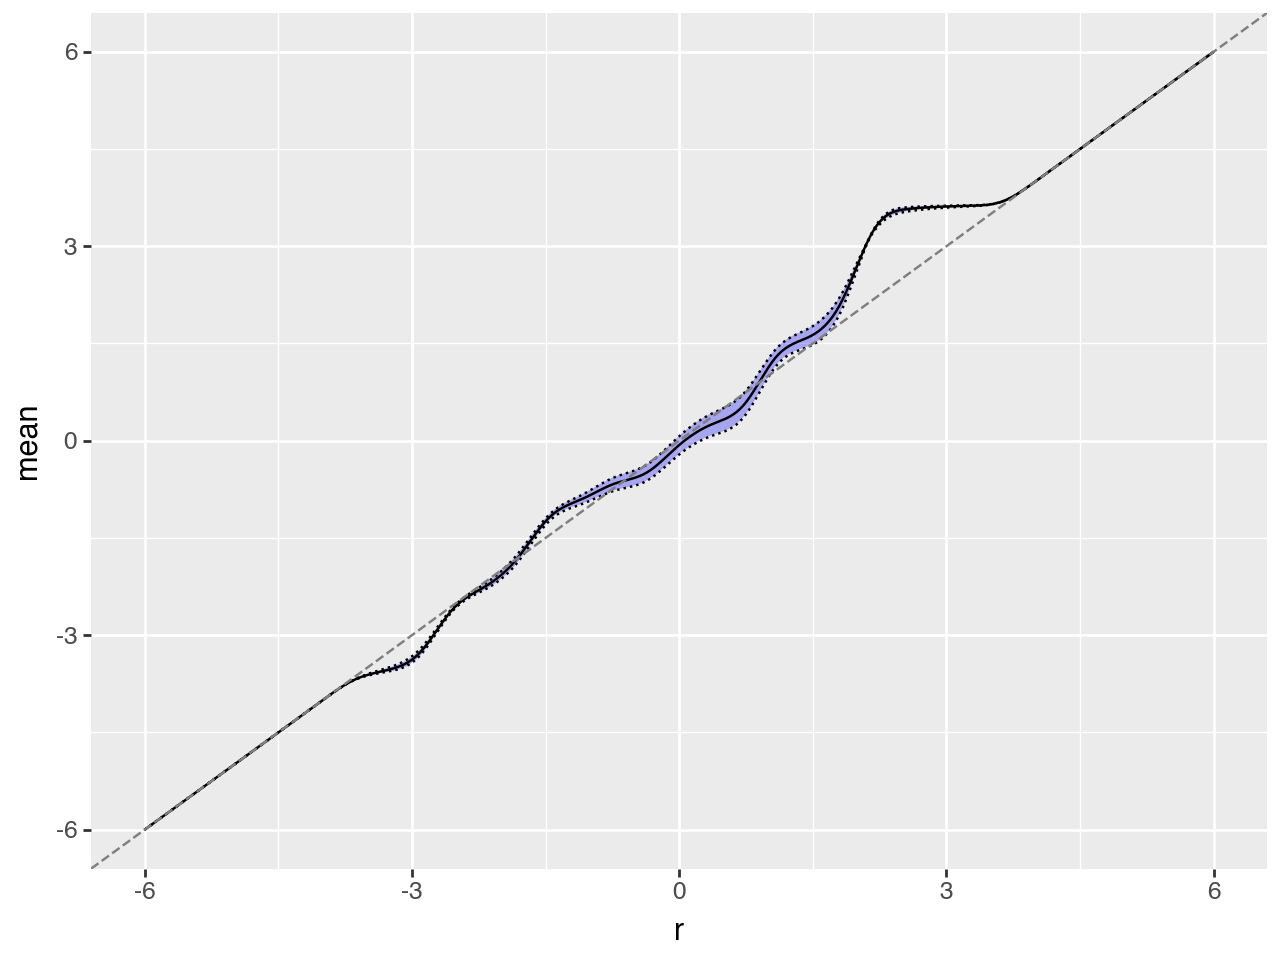

In [40]:
z_summary = gs.SamplesSummary({"z": z}).to_dataframe().reset_index()
z_summary["r"] = rgrid

(
    p9.ggplot(z_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="blue", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
    + p9.geom_abline(intercept=0.0, slope=1.0, linetype="dashed", color="grey")
)

In [41]:
pdf_samples = model.summarise_trafo_by_samples(
    jax.random.key(101), grid=rgrid, samples=samples
)
pdf_samples.head()

,z,cdf,pdf,index,obs,chain,sample,r
0,-6.00,9.865876e-10,6.075883e-09,0,0,3,0,-6.00
1,-5.96,1.261190e-09,7.717784e-09,1,1,3,0,-5.96
2,-5.92,1.609708e-09,9.787708e-09,2,2,3,0,-5.92
3,-5.88,2.051332e-09,1.239294e-08,3,3,3,0,-5.88
4,-5.84,2.610041e-09,1.566654e-08,4,4,3,0,-5.84


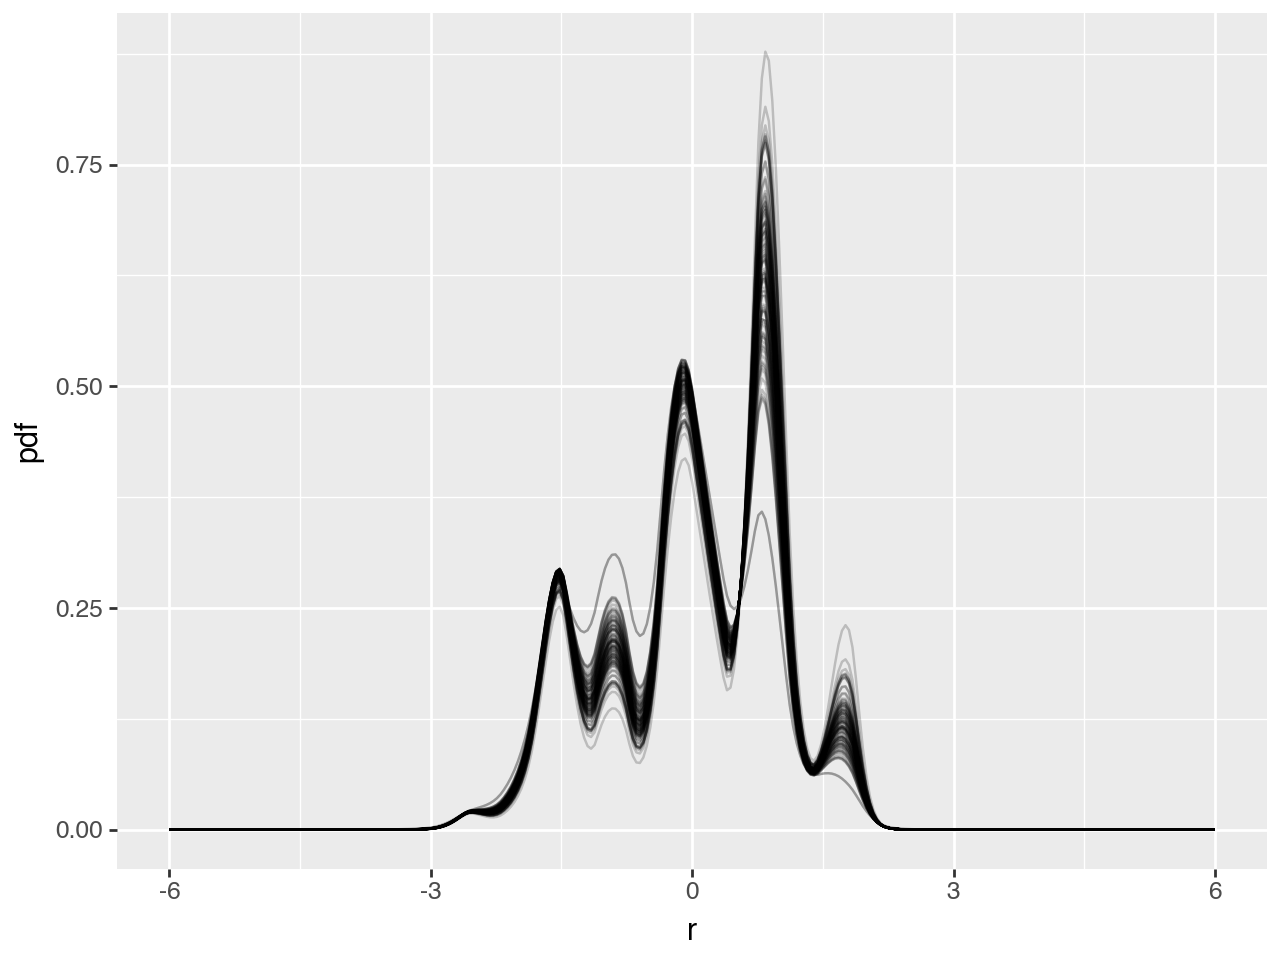

In [42]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "pdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

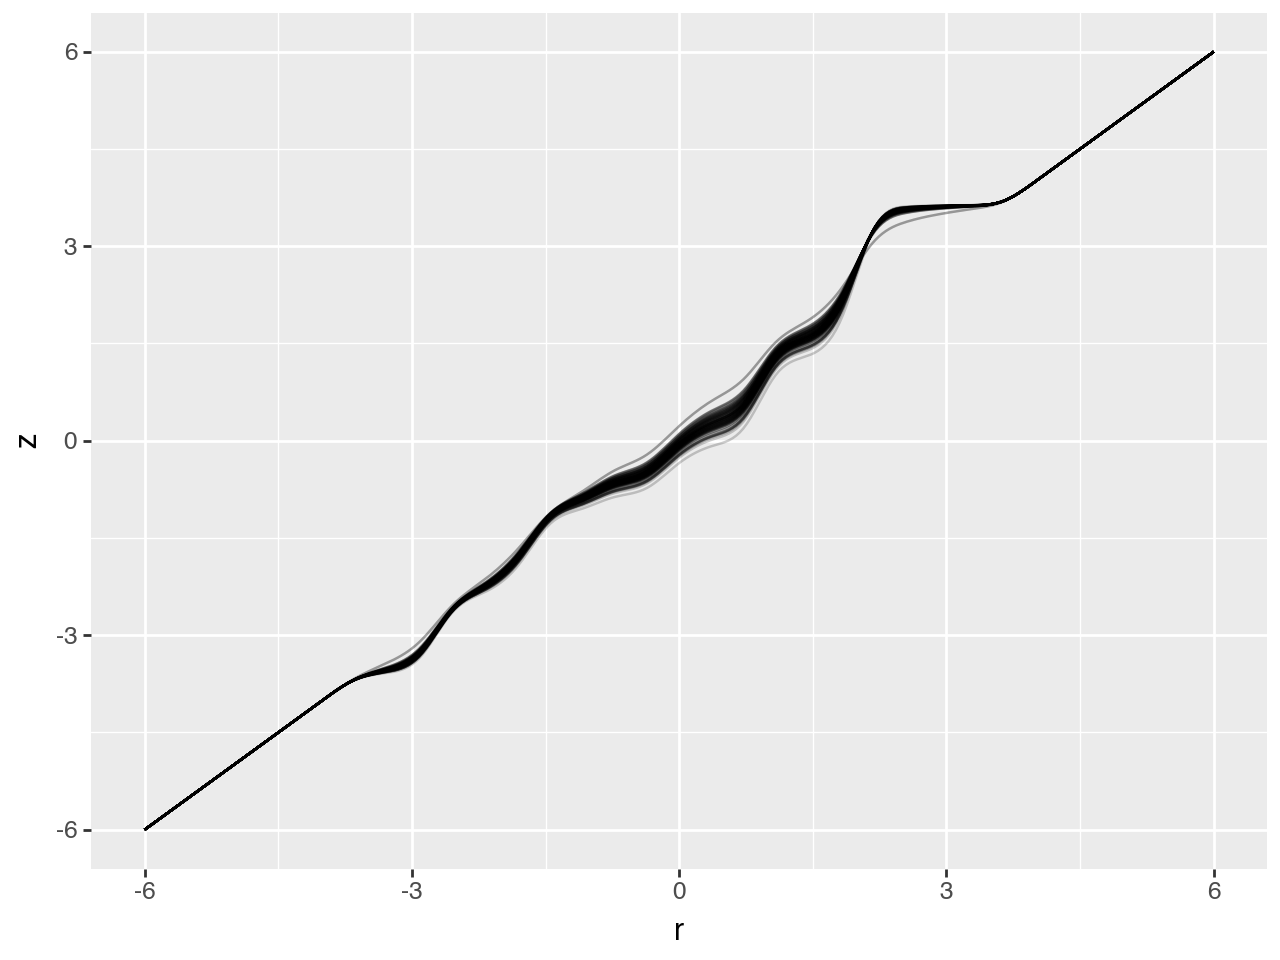

In [43]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "z")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

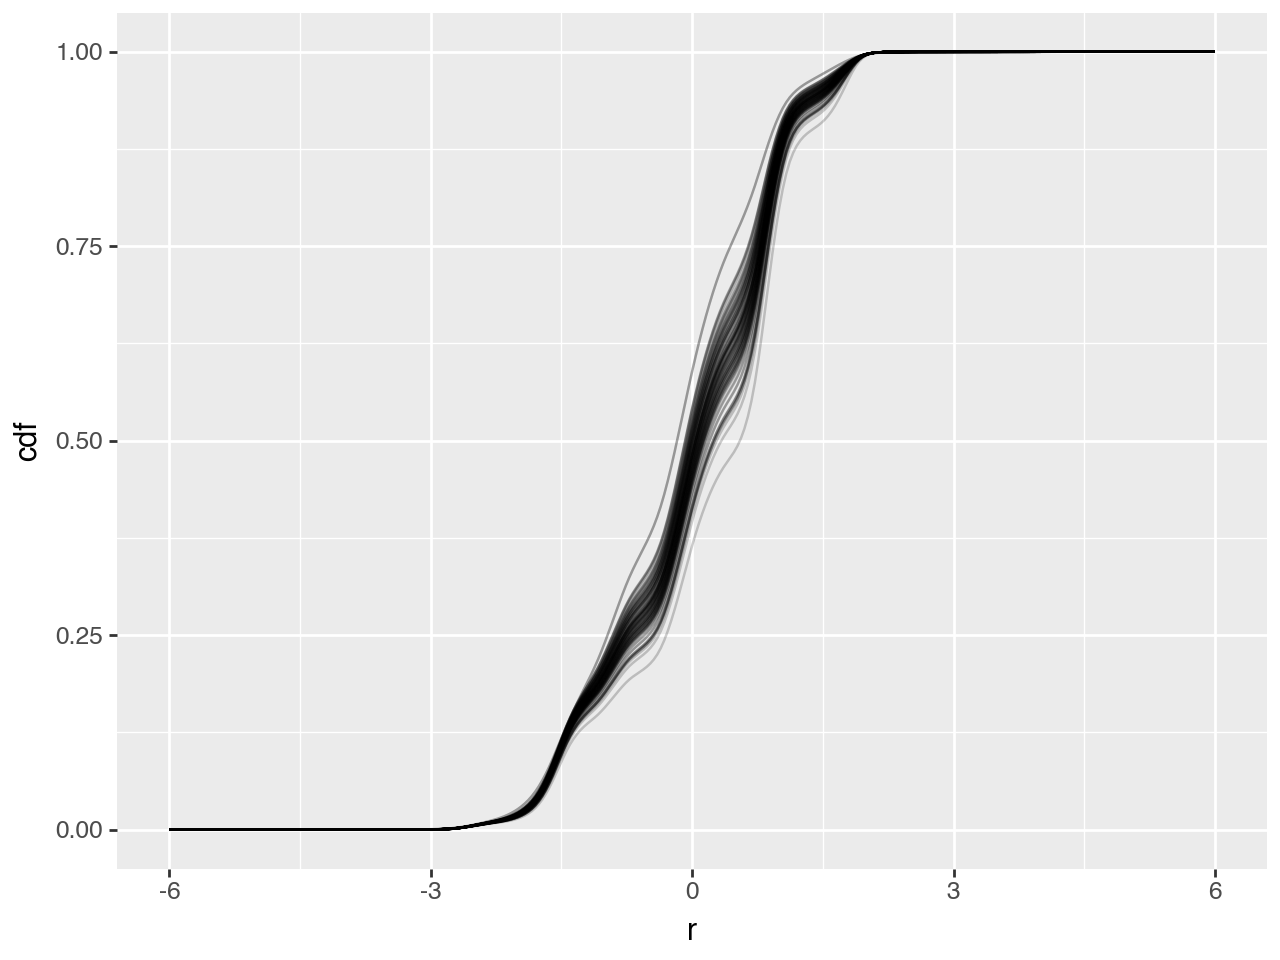

In [44]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "cdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)